In [1]:
# download visualization file
import requests
url = 'https://raw.githubusercontent.com/yigitatesh/ml/main/plots.py'
r = requests.get(url)

with open('plots.py', 'w') as f:
    f.write(r.text)

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from plots import plot_classifier, plot_decision_boundary

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles, make_swiss_roll

# Neural Networks Classifier

### Forward Propagation

$$
A^{[0]} = X \\
$$
$$
Z^{[l]} = W^{[l]}.A^{[l-1]} + b^{[l]} \\
A^{[l]} = g^{[l]}(Z^{[l]})
$$

### Loss Function

$$
L(\hat{y}, y) = -y.log(\hat{y}) - (1-y).log(1 - \hat{y})
$$

### Activation Functions

#### Sigmoid

$$
\sigma(z) = \frac{1}{1 + e^{-z}} \\
$$

Derivative of Sigmoid
$$
\sigma'(z) = \sigma(z).(1 - \sigma(z))
$$

#### Relu

ReLU(z) = Max(0, z) <br> <br>
Derivative of ReLU

$$
ReLU'(z) = \left\{
                    \begin{array}\\
                        0 & \mbox{if} \,\ z < 0 \\
                        1 & \mbox{if} \,\ z >= 0 \\
                    \end{array}
                   \right.
$$

### Shapes

$$
W^{[l]}: (n^{[l]}, n^{[l-1]}) \\
b^{[l]}: (n^{[l]}, 1) \\
Z^{[l]}: (n^{[l]}, m) \\
A^{[l]}: (n^{[l]}, m) \\
$$

### Backpropagation

    For last layer (L):

$$
\frac{dL}{dZ^{[L]}} = A^{[L]} - Y \\
$$

    For other layers (l):

$$
\frac{dL}{dZ^{[l]}} = (W^{[l+1].T}.\frac{dL}{dZ^{[l+1]}})\space * \space g^{[l]}\,'(Z^{[l]}) \\
$$

    Common For all layers (l):

$$
\frac{dL}{dW^{[l]}} = \frac{dZ^{[l]}.A^{[l-1].T}}{m}
$$

$$
\frac{dL}{db^{[l]}} = \frac{Sum(dZ^{[l]},\,axis=1,\,keepdims=True)}{m}
$$

In [3]:
# Neural Networks classifier class
class NNClassifier:
    def __init__(self, hidden_layers=[], learning_rate=0.01, max_iter=1000):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.cache = {}
        
    def fit(self, X, y):
        self.X = X.T
        self.y = y.reshape(1, -1)
        
        self.layers = [self.X.shape[0]] + self.hidden_layers + [1]
        self.L = len(self.layers)
        self.m = self.X.shape[1]
        self.costs = []
        
        # init weights
        self.initialize_weights()
        
        # learning loop
        for i in range(self.max_iter):
            # forward prop
            y_hat = self.forward_propagate(self.X)
            
            # cost
            cost = self.calculate_cost(y_hat, self.y)
            self.costs.append(cost)
            
            # back prop
            self.backward_propagate()
            
            # update weights
            self.update_weights()
            
        return self
        
    def initialize_weights(self):
        for l in range(1, self.L):
            self.cache["W" + str(l)] = np.random.randn(self.layers[l], self.layers[l-1]) * np.sqrt(2 / self.layers[l-1])
            self.cache["b" + str(l)] = np.zeros((self.layers[l], 1))
    
    def forward_propagate(self, X):
        self.cache["A0"] = X
        
        # relu layers
        for l in range(1, self.L-1):
            self.cache["Z" + str(l)] = np.dot(self.cache["W" + str(l)], self.cache["A" + str(l-1)]) + self.cache["b" + str(l)]
            self.cache["A" + str(l)] = self.relu(self.cache["Z" + str(l)])
    
        # sigmoid layer
        l = self.L - 1
        self.cache["Z" + str(l)] = np.dot(self.cache["W" + str(l)], self.cache["A" + str(l-1)]) + self.cache["b" + str(l)]
        self.cache["A" + str(l)] = self.sigmoid(self.cache["Z" + str(l)])
        
        return self.cache["A" + str(l)]
    
    def calculate_cost(self, y_hat, y):
        return -np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))
    
    def backward_propagate(self):
        # sigmoid layer
        l = self.L - 1
        dZ = self.cache["A" + str(l)] - self.y
        self.cache["dW" + str(l)] = np.dot(dZ, self.cache["A" + str(l-1)].T) / self.m
        self.cache["db" + str(l)] = np.sum(dZ, axis=1, keepdims=True) / self.m
        
        # relu layers
        for l in reversed(range(1, self.L-1)):
            dZ = np.dot(self.cache["W" + str(l+1)].T, dZ) * self.d_relu(self.cache["Z" + str(l)])
            self.cache["dW" + str(l)] = np.dot(dZ, self.cache["A" + str(l-1)].T) / self.m
            self.cache["db" + str(l)] = np.sum(dZ, axis=1, keepdims=True) / self.m
    
    def update_weights(self):
        for l in range(1, self.L):
            W = self.cache["W" + str(l)]
            b = self.cache["b" + str(l)]
            self.cache["W" + str(l)] = W - self.learning_rate * self.cache["dW" + str(l)]
            self.cache["b" + str(l)] = b - self.learning_rate * self.cache["db" + str(l)]
        
    def predict_proba(self, X):
        y_hat = self.forward_propagate(X.T)
        y_hat = y_hat.reshape(-1, 1)
        y_inv = 1 - y_hat
        probs = np.concatenate((y_inv, y_hat), axis=1)
        return probs
        
    def predict(self, X):
        y_hat = self.forward_propagate(X.T)
        return np.where(y_hat > 0.5, 1, 0)
    
    # activation functions
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(Z, 0)
    
    def d_relu(self, Z):
        return np.where(Z > 0, 1, 0)
    
    def score(self, X, y):
        preds = self.predict(X)
        return (preds.ravel() == y.ravel()).mean()

# Tests on Data

### Mushrooms Data

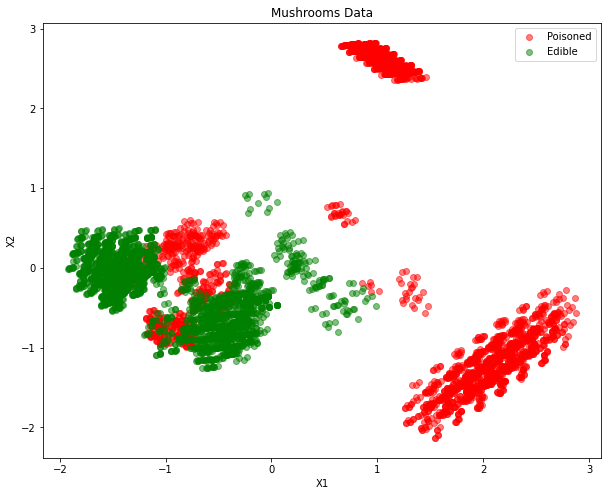

In [9]:
# read data
mushrooms = pd.read_csv("https://raw.githubusercontent.com/yigitatesh/ml/main/datasets/mushrooms.csv")

# one hot encoding
data = pd.get_dummies(mushrooms)

data["edible"] = data["class_e"]
data.drop(["class_e", "class_p"], inplace=True, axis=1)
target_names=["Poisoned", "Edible"]

# X and y split
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# pca
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, random_state=0)

## visualization
X_poisoned = X_train[y_train == 0]
X_edible = X_train[y_train == 1]

plt.figure(figsize=(10, 8))
plt.title("Mushrooms Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X_poisoned[:, 0], X_poisoned[:, 1], color="red", alpha=0.5, label="Poisoned")
plt.scatter(X_edible[:, 0], X_edible[:, 1], color="green", alpha=0.5, label="Edible")
plt.legend()

# Fit Neural Networks with Different layers

### No Hidden Layer (Same with Logistic Regression)

In [10]:
nn = NNClassifier([], learning_rate=0.1, max_iter=1000).fit(X_train, y_train)

train score: 0.8729689807976366, test score: 0.8788774002954209


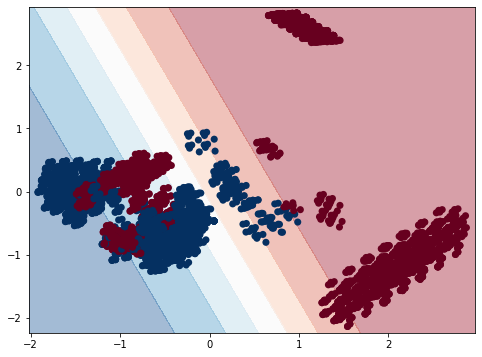

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb19a4dc08>)

In [11]:
# visualize the classification boundaries
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X_2d, y)

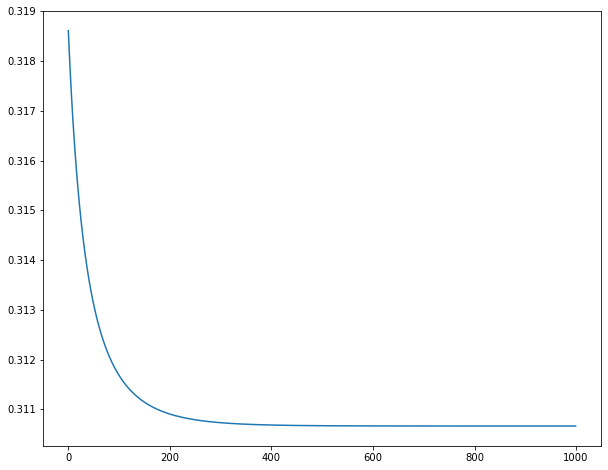

In [12]:
# plot costs
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

### One Hidden Layer

In [25]:
# one hidden layer with 10 neurons
nn = NNClassifier([10], learning_rate=0.1, max_iter=1000).fit(X_train, y_train)

train score: 0.9158050221565731, test score: 0.9226981782373215


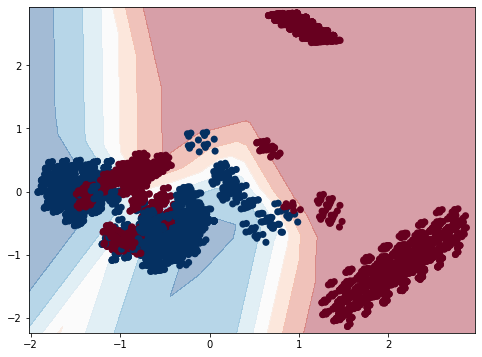

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb1dd1e608>)

In [26]:
# visualize the classification boundaries
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X_2d, y)

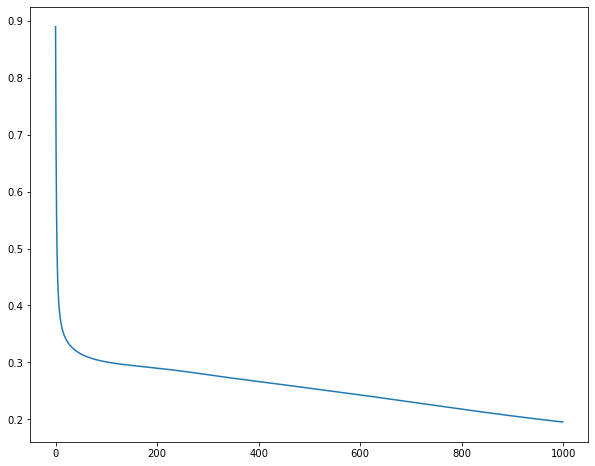

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

In [28]:
# one hidden layer with 20 neurons
nn = NNClassifier([20], learning_rate=0.1, max_iter=1000).fit(X_train, y_train)

train score: 0.9348432627605449, test score: 0.9335302806499262


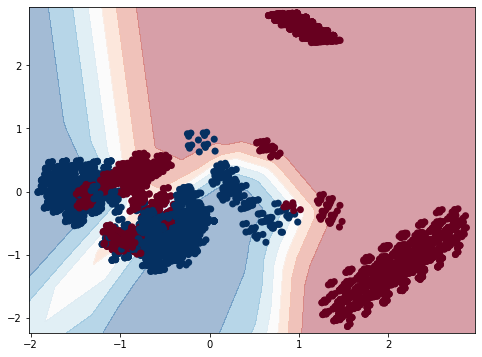

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb1e0ea888>)

In [29]:
# visualize the classification boundaries
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X_2d, y)

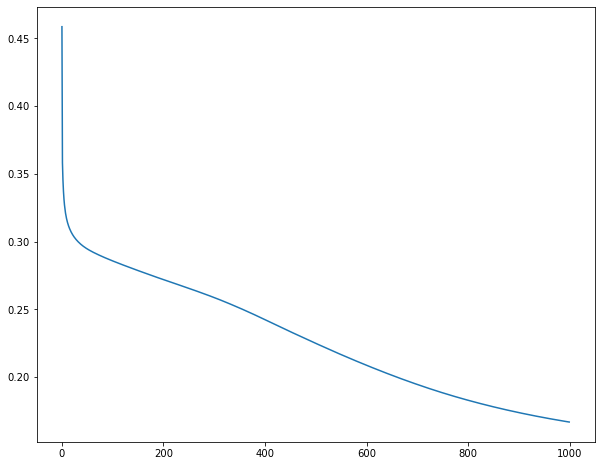

In [30]:
# plot costs
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

### Deep Neural Network

In [31]:
# three hidden layers with 20 neurons
nn = NNClassifier([20, 20, 20], learning_rate=0.1, max_iter=1000).fit(X_train, y_train)

train score: 0.9484654521582143, test score: 0.9507631708517972


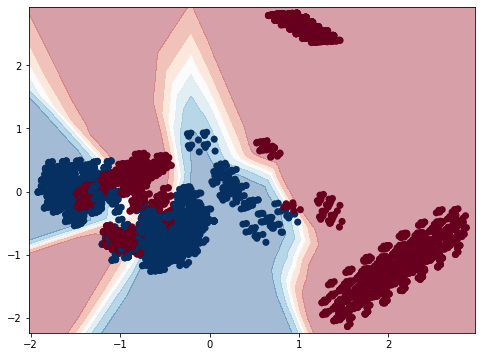

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb1e59d188>)

In [32]:
# visualize the classification boundaries
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X_2d, y)

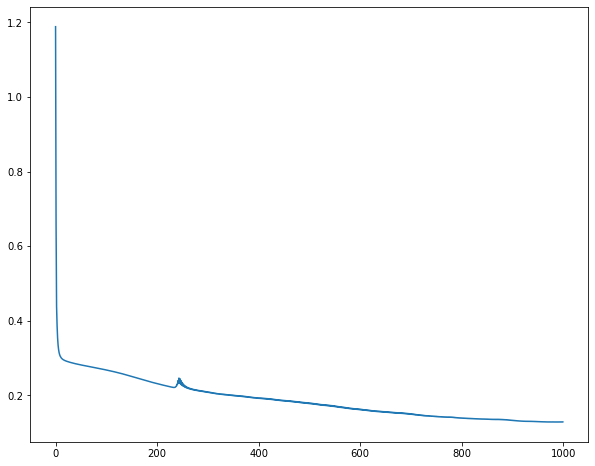

In [33]:
# plot costs
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

## Try with Different Layer Numbers and Neurons

In [34]:
# change layer sizes and neuron numbers
nn = NNClassifier([100], learning_rate=0.1, max_iter=1000).fit(X_train, y_train)

train score: 0.9333661578860988, test score: 0.930576070901034


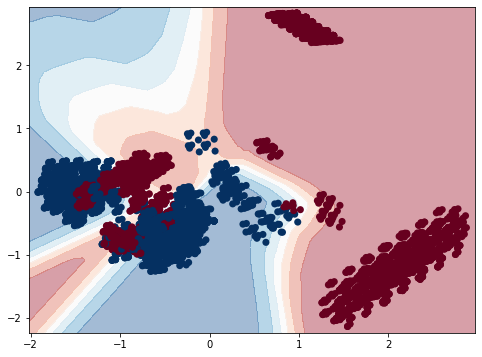

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb1e1d7a08>)

In [35]:
# visualize the classification boundaries
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X_2d, y)

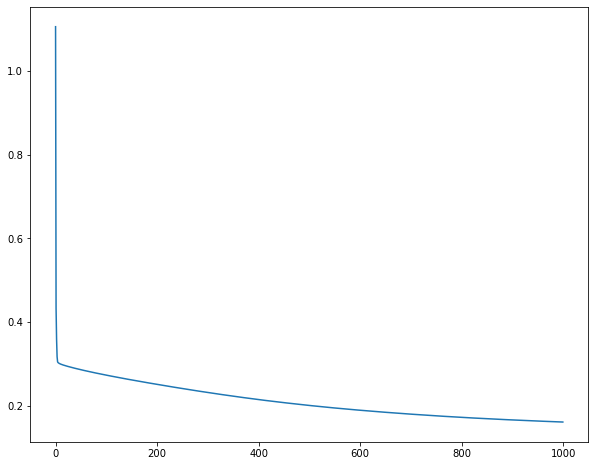

In [36]:
# plot costs
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

## Circle Data

In [96]:
X, y = make_circles(n_samples=400, noise=0.1, random_state=0, factor=0.7)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

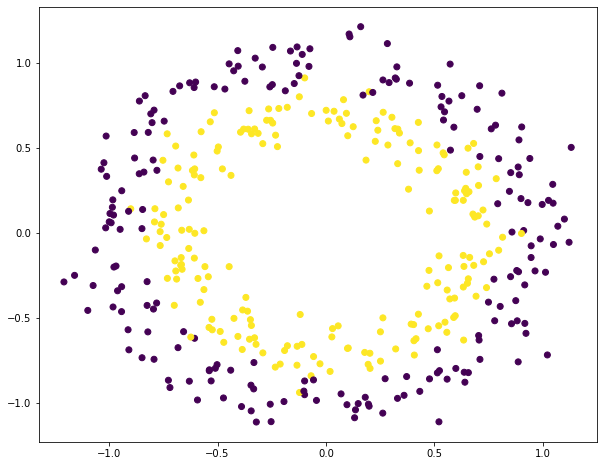

In [97]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [98]:
# fit classifier for circle data
nn = NNClassifier([10], 0.1, 1000).fit(X_train, y_train)

train score: 0.95, test score: 0.96


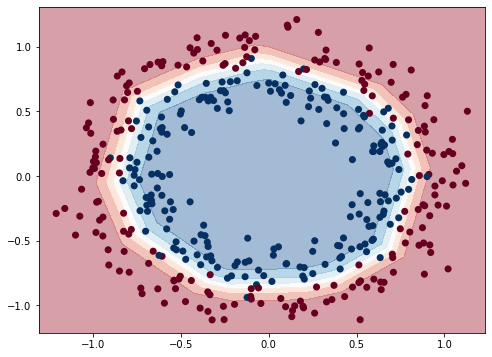

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27887acc448>)

In [100]:
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X, y)

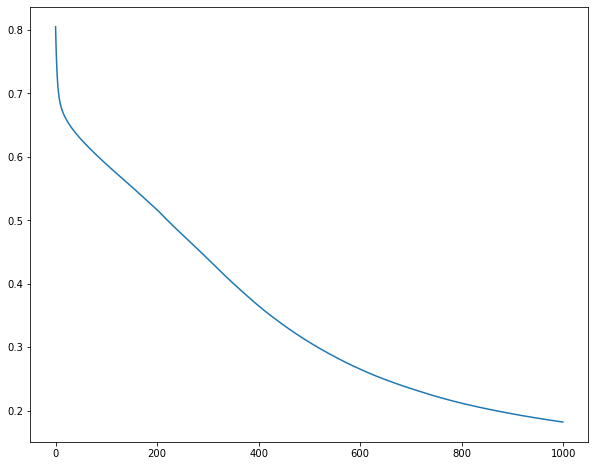

In [99]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

## Swiss Roll

In [101]:
X, y = make_swiss_roll(n_samples=400, noise=0.5, random_state=0)

X = X[:, [0, 2]]
y = np.where(y > y.mean(), 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

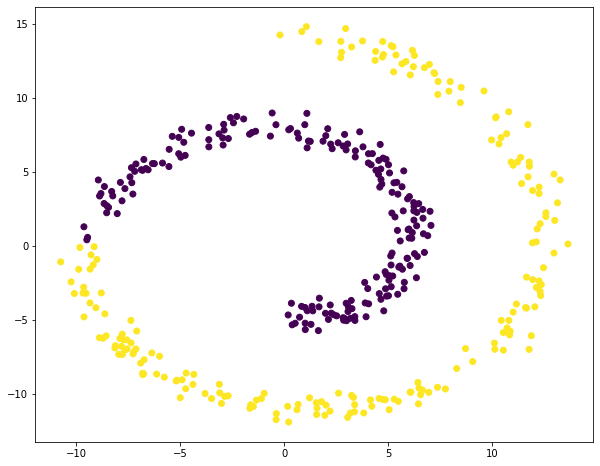

In [102]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [103]:
# fit neural networks for swiss roll data
nn = NNClassifier([10], 0.01, 2000).fit(X_train, y_train)

train score: 0.9933333333333333, test score: 0.99


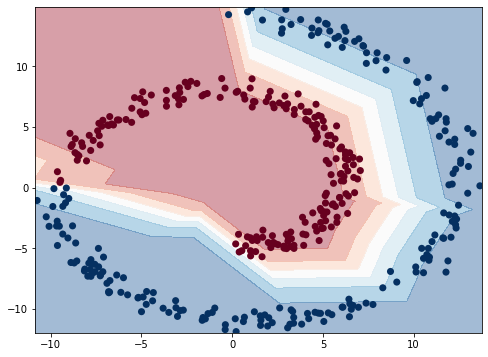

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27887e5f548>)

In [105]:
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X, y)

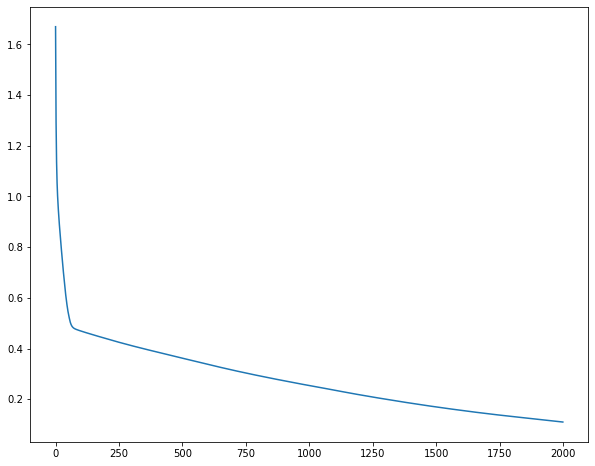

In [104]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)

## XOR Data

In [94]:
# create XOR data
n = 150 # total data size will be 4xn

# X of data
X_upleft = np.concatenate((np.random.uniform(0, 0.5, n).reshape(-1, 1), np.random.uniform(0.5, 1, n).reshape(-1, 1)), axis=1)
X_upright = np.concatenate((np.random.uniform(0.5, 1, n).reshape(-1, 1), np.random.uniform(0.5, 1, n).reshape(-1, 1)), axis=1)
X_downleft = np.concatenate((np.random.uniform(0, 0.5, n).reshape(-1, 1), np.random.uniform(0, 0.5, n).reshape(-1, 1)), axis=1)
X_downright = np.concatenate((np.random.uniform(0.5, 1, n).reshape(-1, 1), np.random.uniform(0, 0.5, n).reshape(-1, 1)), axis=1)

# y of data
y_upleft = np.ones(n)
y_upright = np.zeros(n)
y_downleft = np.zeros(n)
y_downright = np.ones(n)

# concatenate X data and y data
X = np.concatenate((X_upleft, X_upright, X_downleft, X_downright))
y = np.concatenate((y_upleft, y_upright, y_downleft, y_downright))

In [95]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

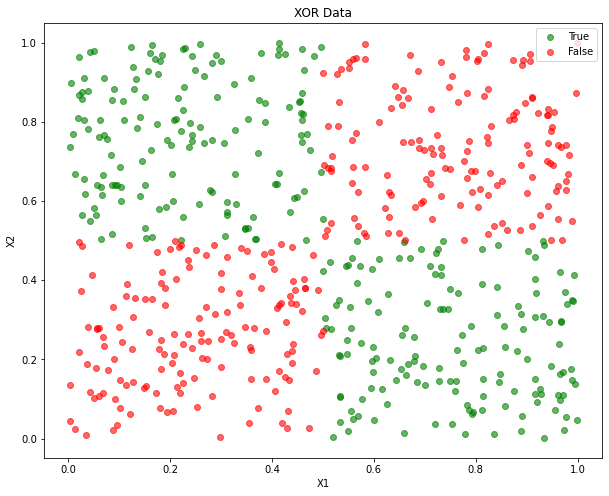

In [96]:
# visualize XOR data
X_False = X[y == 0]
X_True = X[y == 1]

plt.figure(figsize=(10, 8))
plt.title("XOR Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X_True[:, 0], X_True[:, 1], color="green", alpha=0.6, label="True")
plt.scatter(X_False[:, 0], X_False[:, 1], color="red", alpha=0.6, label="False")
plt.legend()

In [97]:
# fit classifier for XOR data
nn = NNClassifier([20, 20], 0.1, 2000).fit(X_train, y_train)

train score: 0.98, test score: 0.9666666666666667


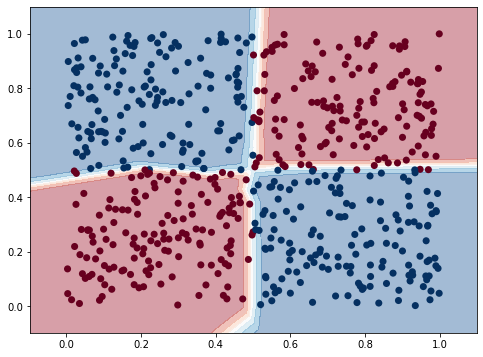

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20e81e0e6c8>)

In [98]:
train, test = nn.score(X_train, y_train), nn.score(X_test, y_test)
print("train score: {}, test score: {}".format(train, test))
plot_decision_boundary(nn, X, y)

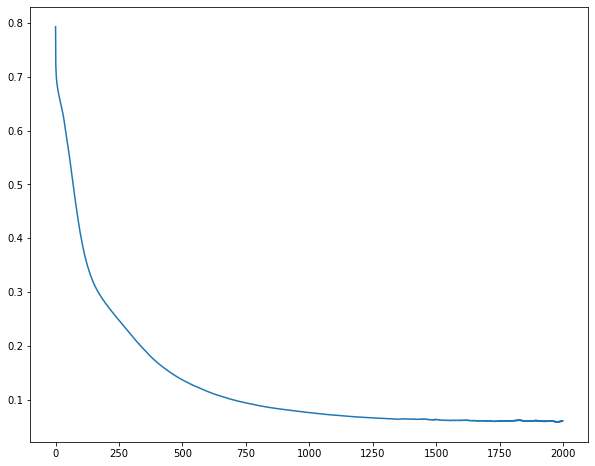

In [99]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(nn.costs)), nn.costs)